### Importing Libraries and Data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import sklearn.metrics as sm
import re

In [20]:
df = pd.read_csv('../website_classification.csv')
df.head(5)

,website_url,cleaned_website_text,Category
0,https://www.fubo.tv/lp/StreamTV/?irad=343747&i...,stream live tv sports fubotv free trial sport ...,Streaming Services
1,https://www.hulu.com/,stream tv movie live online hulu watch tv show...,Streaming Services
2,https://tv.youtube.com/,youtube tv watch dvr live sports shows news st...,Streaming Services
3,https://www.attwatchtv.com/,watchtv stream channel live tv want watchtv ex...,Streaming Services
4,https://www.klowdtv.com/,live tv streaming klowdtv klowdtv provide live...,Streaming Services


In [21]:
df.info() #checking if there is any Nan or null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   website_url           1096 non-null   object
 1   cleaned_website_text  1096 non-null   object
 2   Category              1096 non-null   object
dtypes: object(3)
memory usage: 25.8+ KB


In [22]:
df["Category"].value_counts()

Computers and Technology           258
Social Networking and Messaging    115
Business/Corporate                 108
Streaming Services                 103
E-Commerce                         101
Sports                             100
Games                               98
News                                93
Law and Government                  83
Adult                               21
Forums                              16
Name: Category, dtype: int64

### Visualising distribution of website categories

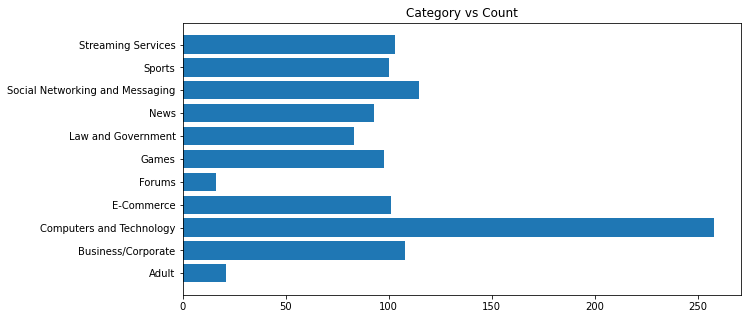

In [23]:
#visualising the count of each category
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
site_category_count = pd.DataFrame(df.groupby(df['Category']).size(),columns=['Count'])
plt.barh(width=site_category_count['Count'],y=site_category_count.index)
plt.show()

In [24]:
site_category_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, Adult to Streaming Services
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   11 non-null     int64
dtypes: int64(1)
memory usage: 176.0+ bytes


In [25]:
print("Different categories of websites: ",len(site_category_count["Count"]))

Different categories of websites:  11


### Data Cleaning & Engineering

##### NLP pipeline
##### 1. Text processing
######    - Cleaning
######    - Normalization (changing to lowercase and removing punctuation)
######    - Word Tokenisation
######    - Remove stop words
######    - Remove Non-alpha text
######    - Word Stemming and Lemmatization

##### 2. Feature Engineering
######    - Label Encoding for Categories
######    - Bag of Words (CountVectorizer)
######    - TF-IDF (Bag of Words + Tf-IDF = TfidfVectorizer)
######    - Word Embeddings (word2vec/glove)

##### 3. Feature Selection

In [26]:
df.drop(columns=['website_url'],inplace=True)

In [27]:
df.tail()

,cleaned_website_text,Category
1091,slack is your productivity platform slackslack...,Social Networking and Messaging
1092,discord your place to talk and hang outdiscord...,Social Networking and Messaging
1093,dribbble discover the worlds top designers cre...,Social Networking and Messaging
1094,product hunt the best new products in tech pr...,Social Networking and Messaging
1095,goodreads meet your next favorite bookfind and...,Social Networking and Messaging


Normalizing text: convert to lowercase and remove punctuation

In [28]:
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: x.lower())
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))

In [29]:
df.head()

,cleaned_website_text,Category
0,stream live tv sports fubotv free trial sport ...,Streaming Services
1,stream tv movie live online hulu watch tv show...,Streaming Services
2,youtube tv watch dvr live sports shows news st...,Streaming Services
3,watchtv stream channel live tv want watchtv ex...,Streaming Services
4,live tv streaming klowdtv klowdtv provide live...,Streaming Services


Tokenising: Split sentence into list of words

In [30]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: word_tokenize(x))
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,cleaned_website_text,Category
0,"[stream, live, tv, sports, fubotv, free, trial...",Streaming Services
1,"[stream, tv, movie, live, online, hulu, watch,...",Streaming Services
2,"[youtube, tv, watch, dvr, live, sports, shows,...",Streaming Services
3,"[watchtv, stream, channel, live, tv, want, wat...",Streaming Services
4,"[live, tv, streaming, klowdtv, klowdtv, provid...",Streaming Services
...,...,...
1091,"[slack, is, your, productivity, platform, slac...",Social Networking and Messaging
1092,"[discord, your, place, to, talk, and, hang, ou...",Social Networking and Messaging
1093,"[dribbble, discover, the, worlds, top, designe...",Social Networking and Messaging
1094,"[product, hunt, the, best, new, products, in, ...",Social Networking and Messaging


Removing Stopwords

In [31]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [word for word in x if word not in stop_words])
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,cleaned_website_text,Category
0,"[stream, live, tv, sports, fubotv, free, trial...",Streaming Services
1,"[stream, tv, movie, live, online, hulu, watch,...",Streaming Services
2,"[youtube, tv, watch, dvr, live, sports, shows,...",Streaming Services
3,"[watchtv, stream, channel, live, tv, want, wat...",Streaming Services
4,"[live, tv, streaming, klowdtv, klowdtv, provid...",Streaming Services
...,...,...
1091,"[slack, productivity, platform, slackslack, ne...",Social Networking and Messaging
1092,"[discord, place, talk, hang, outdiscord, easie...",Social Networking and Messaging
1093,"[dribbble, discover, worlds, top, designers, c...",Social Networking and Messaging
1094,"[product, hunt, best, new, products, tech, pro...",Social Networking and Messaging


Word Stemming and Lemmatization

In [32]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
lem = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'
    
#Define function to lemmatize each word with its POS tag
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    pos_tagged_text = [(word, pos_tagger(pos_tag)) for word, pos_tag in pos_tagged_text]
    return [lem.lemmatize(word, pos_tag) for word, pos_tag in pos_tagged_text]

df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: lemmatize_words(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [33]:
#joining tokenized words
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: ' '.join(x))

Feature extraction: Label Encoding

In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [35]:
df.head()

,cleaned_website_text,Category
0,stream live tv sport fubotv free trial sport d...,10
1,stream tv movie live online hulu watch tv show...,10
2,youtube tv watch dvr live sport show news stre...,10
3,watchtv stream channel live tv want watchtv ex...,10
4,live tv stream klowdtv klowdtv provide live tv...,10


In [36]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['cleaned_website_text'],df['Category'],test_size=0.2,random_state=0)

In [37]:
X_train

384     welcome upsc upsc search form union public ser...
351     baltic word baltic word provide timely objecti...
1057    facebook log sign uplog facebook start share c...
622     designer italian shoe accessory unique collect...
188     arseblog arseblog arsenal blog arseblog arsena...
                              ...                        
1033    onelogin marketleading identity access managem...
763     home globalstar globalstar offer connectivity ...
835     mtm centre leadership management development m...
559     aelyria forward forums welcome aelyria page au...
684     access deny charles river analytics charles ri...
Name: cleaned_website_text, Length: 876, dtype: object

Feature extraction: Tf-idf vectorizer

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_id_vectorizer = TfidfVectorizer(max_features=5000)
tf_id_train = tf_id_vectorizer.fit_transform(X_train)
tf_id_test = tf_id_vectorizer.transform(X_test)

In [39]:
tf_id_train = tf_id_train.toarray()
tf_id_test = tf_id_test.toarray()

Model training

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data (X_train) and corresponding labels (y_train)

# Define the models and their respective hyperparameters to try during grid search
models = {
    'MNB': {
        'model': MultinomialNB(),
        'params': {
            'mnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'svm__C': [1, 10, 100],
            'svm__kernel': ['linear', 'rbf']
        }
    }
}

# Perform grid search and cross-validation for each model
for model_name, model_data in models.items():
    print("Evaluating:", model_name)
    
    # Create a pipeline with a TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        (model_name.lower(), model_data['model'])
    ])
    
    # Define the hyperparameters for the current model
    parameters = model_data['params']
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
    grid_search.fit(tf_id_train, y_train)
    
    # Get the best model and its corresponding hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions on the test set
    y_pred = best_model.predict(tf_id_test)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Best parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("----------------------------------")

Evaluating: MNB


c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'mnb__alpha': 0.1}
Accuracy: 0.9136363636363637
Precision: 0.8955786560637525
Recall: 0.9136363636363637
F1 score: 0.8991307700244717
----------------------------------
Evaluating: SVM
Best parameters: {'svm__C': 1, 'svm__kernel': 'linear'}
Accuracy: 0.9363636363636364
Precision: 0.9378120015948963
Recall: 0.9363636363636364
F1 score: 0.9302341613287307
----------------------------------


In [41]:
model = SVC(C=1,kernel='linear')
model.fit(tf_id_train,y_train)

SVC(C=1, kernel='linear')

In [42]:
import sklearn.metrics as sm

y_pred = model.predict(tf_id_test)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,model.predict(tf_id_train))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 0.9931506849315068
The accuracy of test model is 0.9363636363636364


In [43]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
import os


class ScrapTool:
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        content = requests.get(website_url,timeout=60).content
        soup = BeautifulSoup(content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [44]:
#cleaning text and preprocessing
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)   
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = lemmatize_words(text)
    text = ' '.join(text)
    vector = tf_id_vectorizer.transform([text])
    vector = vector.toarray()
    return vector

In [45]:
def website_prediction(website,model):
    scrapTool = ScrapTool()
    try:
        web = dict(scrapTool.visit_url(website))
        text = cleaning_text(web['website_text'])
        prediction = model.predict(text)
        print(f'The website is under the category of {le.inverse_transform(prediction)[0]}')
    except:
        print("Connection Timeout")

In [46]:
import pickle

filename = 'RootModel.sav'
pickle.dump(model, open(filename, 'wb'))

#loading the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(tf_id_test, y_test)
print(result)

0.9363636363636364


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.85      0.85      0.85        20
           2       0.99      0.92      0.95        72
           3       0.95      0.95      0.95        21
           4       0.20      1.00      0.33         1
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        11
           7       1.00      0.94      0.97        16
           8       0.81      0.89      0.85        19
           9       0.92      1.00      0.96        12
          10       1.00      0.95      0.97        20

    accuracy                           0.94       220
   macro avg       0.88      0.95      0.89       220
weighted avg       0.95      0.94      0.94       220



<AxesSubplot:>

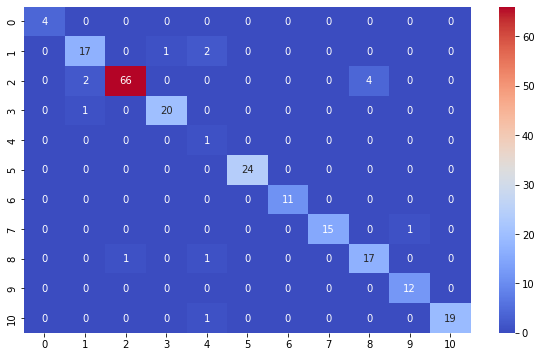

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

plt.figure(figsize=(10,6))
predictions = model.predict(tf_id_test)
print(classification_report(predictions,y_test))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [1]:
pd.set_option('display.max_rows', None)
predictions = model.predict(tf_id_test)
predic_df = pd.DataFrame({'Cleaned Text':X_test,'Actual':y_test,'Predicted':predictions})

NameError: name 'pd' is not defined

In [51]:
website ="https://www.linked.com/"
website_prediction(website,loaded_model)

The website is under the category of Computers and Technology
